In [9]:
# Basket name: Patents+OCHEM+Enamine+Bradley+Begström (training)
# This basket belongs to user: published, created by dan2097

from rdkit.Chem import AllChem, MolFromSmiles, Descriptors
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import tzip
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np

random.seed(42)

In [10]:
HOME = "/home/ec2-user/np-clinical-trials"

In [11]:
coconut_smiles_list = (
    pd.read_csv(f"{HOME}/data/COCONUT_DB.smi", delim_whitespace="\s+", header=None)[0]
    .unique()
    .tolist()
)

/tmp/ipykernel_26944/1433410704.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pd.read_csv(f"{HOME}/data/COCONUT_DB.smi", delim_whitespace="\s+", header=None)[0]


In [12]:
synthetic_smiles_list = (
    pd.read_csv(f"{HOME}/data/DDS-50.smi", delim_whitespace="\s+", header=None)[0]
    .unique()
    .tolist()
)

/tmp/ipykernel_26944/3809046104.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pd.read_csv(f"{HOME}/data/DDS-50.smi", delim_whitespace="\s+", header=None)[0]


In [13]:
OCHEM_subset_smiles_list = (
    pd.read_csv(f"{HOME}/data/OCHEM_data.csv", sep=";")["SMILES"].unique().tolist()
)

/tmp/ipykernel_26944/2529418418.py:2: DtypeWarning: Columns (6,13,14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{HOME}/data/OCHEM_data.csv", sep=";")["SMILES"].unique().tolist()


In [14]:
results_dictionary = {
    "OCHEM": {"SMILES": OCHEM_subset_smiles_list},
    "COCONUT": {"SMILES": coconut_smiles_list},
    "DDS": {"SMILES": synthetic_smiles_list},
}


def conversion_with_rdkit(input_smiles):
    try:
        return MolFromSmiles(input_smiles)
    except:
        return None


fpgen = AllChem.GetRDKitFPGenerator()
for current_subset in results_dictionary:
    molecules_list = []
    with Pool(48) as p:
        molecules_list = list(
            tqdm(
                p.imap(
                    conversion_with_rdkit, results_dictionary[current_subset]["SMILES"]
                ),
                total=len(results_dictionary[current_subset]["SMILES"]),
            )
        )

    results_dictionary[current_subset]["Molecules"] = molecules_list

  1%|▏         | 4028/275132 [00:02<01:47, 2520.70it/s][10:33:57] Explicit valence for atom # 16 S, 9, is greater than permitted
[10:33:57] Explicit valence for atom # 10 S, 9, is greater than permitted
  6%|▌         | 15455/275132 [00:03<00:19, 13137.05it/s][10:33:57] Explicit valence for atom # 14 S, 9, is greater than permitted
[10:33:57] Explicit valence for atom # 11 S, 9, is greater than permitted
[10:33:57] Explicit valence for atom # 10 S, 9, is greater than permitted
  9%|▉         | 25661/275132 [00:03<00:11, 22193.54it/s][10:33:58] Explicit valence for atom # 30 S, 9, is greater than permitted
[10:33:58] Explicit valence for atom # 22 S, 9, is greater than permitted
[10:33:58] Explicit valence for atom # 24 S, 9, is greater than permitted
[10:33:58] Explicit valence for atom # 29 S, 9, is greater than permitted
 12%|█▏        | 31706/275132 [00:03<00:09, 24957.94it/s][10:33:58] Explicit valence for atom # 12 S, 9, is greater than permitted
[10:33:58] Explicit valence for at

In [15]:
fpgen = AllChem.GetRDKitFPGenerator()

In [16]:
def calculate_fingerprints(input_molecule):
    try:
        return Descriptors.CalcMolDescriptors(input_molecule)
    except:
        return None


for current_subset in results_dictionary:
    fps_list, valid_smiles = [], []
    with Pool(48) as p:
        fps_list = list(
            tqdm(
                p.imap(
                    calculate_fingerprints,
                    results_dictionary[current_subset]["Molecules"],
                ),
                total=len(results_dictionary[current_subset]["Molecules"]),
            )
        )
    valid_smiles = []
    for current_smiles, current_fingerprint in tzip(
        results_dictionary[current_subset]["SMILES"], fps_list
    ):
        if current_fingerprint is not None:
            valid_smiles.append(current_smiles)
        else:
            valid_smiles.append(None)

    fps_df = pd.DataFrame(fps_list)
    fps_df["SMILES"] = valid_smiles
    fps_df["source"] = current_subset
    results_dictionary[current_subset]["features"] = fps_df

100%|██████████| 50063/50063 [00:00<00:00, 1999518.56it/s]


In [17]:
full_fingerprints_df = pd.concat(
    [
        results_dictionary["OCHEM"]["features"],
        results_dictionary["COCONUT"]["features"],
        results_dictionary["DDS"]["features"],
    ]
)

In [18]:
full_fingerprints_df.to_csv(f"{HOME}/data/full_fingerprints_df.parquet", index=False)

In [19]:
full_fingerprints_df = pd.read_csv(f"{HOME}/data/full_fingerprints_df.parquet")

In [20]:
ids_columns = full_fingerprints_df[["source", "SMILES"]]
features_df = full_fingerprints_df.drop(columns=["SMILES", "source"])

In [21]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    features_df.replace([np.inf, -np.inf], np.nan).fillna(0)
)
scaled_features = pd.DataFrame(
    scaled_features, columns=features_df.columns, index=ids_columns.index
)

In [22]:
PCA_object = PCA(n_components=2)
PCA_features = PCA_object.fit_transform(scaled_features)

In [23]:
usable_df = pd.DataFrame(PCA_features, columns=["PC1", "PC2"]).reset_index(drop=True)
usable_df["source"] = ids_columns["source"].reset_index(drop=True)

/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ec2-user/np-clinical-trials

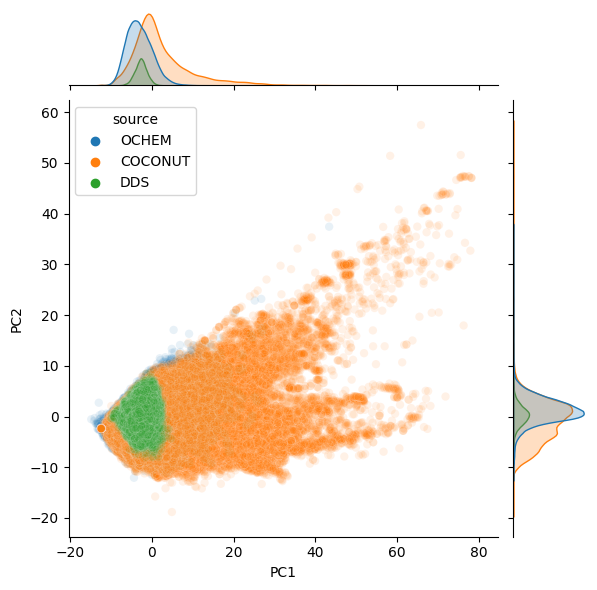

In [25]:
# Create a jointplot with Seaborn
sns.jointplot(
    data=usable_df,
    x="PC1",
    y="PC2",
    hue="source",
    alpha=0.1,
)
plt.xlabel("PC1")
plt.ylabel("PC2")


# Optionally, you can save the plot to a file
plt.savefig("PCA_plot.png", format="png", dpi=600)
plt.show()